In [1]:
import PointNet
import VoxNet
import ModelNet
#import KITTI
import ISO

#point_in_cloud = 2048
#model = PointNet.PointNet(classes=10, load_weights=True, num_points=point_in_cloud)
#predict = PointNet.predict
#x_train, y_train, x_test, y_test = ModelNet.loadmodelnet(classes=10, vox=False)

#model = VoxNet.VoxNet(classes=40, load_weights=True)
#predict = VoxNet.predict
#x_train, y_train, x_test, y_test = ModelNet.loadmodelnet(classes=40, vox=True)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0         
__________

In [2]:
import numpy as np
import h5py
"""
train_path = 'Data/KITTI_train/kitti_train_3.h5'
test_path = 'Data/KITTI_train/kitti_test_3.h5'
def load_data(path):
    f = h5py.File(path, 'r')
    X_train = np.asarray(list(f['data']))
    Y_train = np.asarray(list(f['label']))

    # Normalize the data
    for i in X_train:
        i -= np.min(i, axis=0)
        i[:,0] /= max(i[:,0]) - min(i[:,0])
        i[:,1] /= max(i[:,1]) - min(i[:,1])
        i[:,2] /= max(i[:,2]) - min(i[:,2])
    #m = max(X_train.min(), X_train.max(), key=abs)
    #X_train /= m # This puts the data in [0,1]
    return X_train, Y_train

X_train, Y_train = load_data(train_path)
X_test, Y_test = load_data(test_path)
"""

"\ntrain_path = 'Data/KITTI_train/kitti_train_3.h5'\ntest_path = 'Data/KITTI_train/kitti_test_3.h5'\ndef load_data(path):\n    f = h5py.File(path, 'r')\n    X_train = np.asarray(list(f['data']))\n    Y_train = np.asarray(list(f['label']))\n\n    # Normalize the data\n    for i in X_train:\n        i -= np.min(i, axis=0)\n        i[:,0] /= max(i[:,0]) - min(i[:,0])\n        i[:,1] /= max(i[:,1]) - min(i[:,1])\n        i[:,2] /= max(i[:,2]) - min(i[:,2])\n    #m = max(X_train.min(), X_train.max(), key=abs)\n    #X_train /= m # This puts the data in [0,1]\n    return X_train, Y_train\n\nX_train, Y_train = load_data(train_path)\nX_test, Y_test = load_data(test_path)\n"

In [3]:
import numpy as np
predict(x_test[0], model)
#model.evaluate(np.swapaxes(x_test,1,-1), y_test)
print model.evaluate(x_test, y_test)


predict = PointNet.predict

1504/1514 [============================>.] - ETA: 0s[0.5368156857306293, 0.8612945837262757]


In [4]:
# The only real functions we need from the model implimentation is the 
# Critical set calculations

#predict = #method for predictions from model
get_cs = PointNet.get_critical_set #method for calculating critical set from model

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.min(dist_2) #argmin will give us the index, right now we want the l2 distance

def ISO_point(inp, label, model, monotone=True):
    confidences = [1]
    removed = []
    removed_ind = []
    points_occluded = 0
    x = list(inp)
    y = np.argmax(label)
    
    # First you have to calculate an all pairs distance
    # and keep a matrix of points with the smallest change
    nearest_neighbors = []
    for i in range(len(x)):
        replace = x[0]
        del x[0]
        nearest_neighbors.append(closest_node(replace, x))
        x.append(replace)
        
    conf_i, cl = predict(x,model)
    if(cl != y):
        return 0,0,0,0
    
    # Calculate the critical set
    iterations = 0
    while(True):
        iterations += 1
        cs = get_cs(model, x)
        card_cs = len(cs)
        # Invert sort the critical set by the distance to the nearest neighbor
        cs = [c for _,c in sorted(zip(nearest_neighbors,cs))]
        cs = reversed(cs)
        
        # Manipulate and undo manipulations that increase the confidence 
        # of the network
        att = 0
        for i in cs:
            _replace = x[i]
            x[i] = [0,0,0] 
            conf, cl = predict(x,model)
            #if(monotone and iterations > 1800):
            #    montone = False
            if(monotone and conf <= conf_i):
                conf_i = conf
            elif(monotone):
                x[i] = _replace
                att += 1
                sys.stdout.write("Point missed: %s \r"%(att))
                sys.stdout.flush()
                if(att > card_cs-2):
                    print "Non-monotonic"
                    return 1024, -1, -1, -1
                continue
            sys.stdout.write("Points occluded: %s conf: %s \r"%(points_occluded, conf))
            sys.stdout.flush()
            if(cl != y):
                # lets refine the adversarial example:
                actually_removed = []
                actually_removed_ind = []
                for i in range(len(removed)):
                    x[removed_ind[i]] = removed[i]
                    conf, cl = predict(x,model)
                    if(cl == y):
                        x[removed_ind[i]] = [0,0,0]
                        actually_removed.append(removed[i])
                        actually_removed_ind.append(removed_ind[i])
                        points_occluded -= 1
                    #sys.stdout.write("Points occluded: %s conf: %s \r"%(points_occluded, conf))
                    #sys.stdout.flush()
                #print " "
                return len(actually_removed), x, actually_removed, actually_removed_ind                 
            # Without refinement
            #if(cl != y):
            #    return len(removed), x, removed, removed_ind 
            #if(conf >= confidences[-1] and iterations == 0):
            #    x[i] = _replace
            #    continue
            removed.append(_replace)
            removed_ind.append(i)
            points_occluded += 1
            confidences.append(conf)
        conf, cl = predict(x,model)
        if(points_occluded > 1024 and monotone == False):
            print("STARTING OVER")
            return -1, -1, -1, -1
    print "Misclassification via Occlusion is impossible"
    
    

In [5]:
"""
def get_critical_set_bb(model, point_cloud):
    critical_set = []
    values = []
    #v_init, c_init = predict(point_cloud, model)
    pc = copy.deepcopy(point_cloud)	
    for i in range(len(pc)):
        val = copy.deepcopy(pc[i])
        pc[i] = [0.0,0.0,0.0]
        v, c = predict(pc, model)
        values.append(v)
        pc[i] = val
    unique = np.unique(values,return_index=True)
    return unique[1]

cs = get_critical_set_bb(model, X_test[1])
print len(cs)
cs = PointNet.get_critical_set(model, X_test[1])
print len(cs)
"""

'\ndef get_critical_set_bb(model, point_cloud):\n    critical_set = []\n    values = []\n    #v_init, c_init = predict(point_cloud, model)\n    pc = copy.deepcopy(point_cloud)\t\n    for i in range(len(pc)):\n        val = copy.deepcopy(pc[i])\n        pc[i] = [0.0,0.0,0.0]\n        v, c = predict(pc, model)\n        values.append(v)\n        pc[i] = val\n    unique = np.unique(values,return_index=True)\n    return unique[1]\n\ncs = get_critical_set_bb(model, X_test[1])\nprint len(cs)\ncs = PointNet.get_critical_set(model, X_test[1])\nprint len(cs)\n'

In [6]:
import sys
import copy
from tqdm import tqdm
from tqdm import trange
import time
import numpy as np
#get_max_pool = VoxNet.get_max_pool
index = 7
times = []
scores = []
inputs = []
adversaries = []
zeros = 0
samples = 10
#order = np.random.permutation(len(Y_test))
for i in trange(samples):
    index = i
    start = time.time()
    a,b,c,d = ISO_point(x_test[index], y_test[index], model, monotone=True)
    if(a == -1):
        a,b,c,d = ISO_point(X_test[index], Y_test[index], model, monotone=False)
    end = time.time()
    scores.append(a)
    if(a == 0):
        zeros += 1
    else:
        times.append(end-start)
        inputs.append(b)
        adversaries.append(c)
    #a,b,c = ISO_vox(x_test[index], y_test[index], model)
    

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:06<00:58,  6.51s/it]

 30%|███       | 3/10 [00:33<01:18, 11.27s/it]

 40%|████      | 4/10 [00:48<01:12, 12.10s/it]

 50%|█████     | 5/10 [01:07<01:07, 13.58s/it]

 60%|██████    | 6/10 [01:25<00:56, 14.24s/it]

 70%|███████   | 7/10 [01:42<00:43, 14.61s/it]

 80%|████████  | 8/10 [01:45<00:26, 13.18s/it]

 90%|█████████ | 9/10 [02:02<00:13, 13.61s/it]

100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


1754


<IPython.core.display.Javascript object>


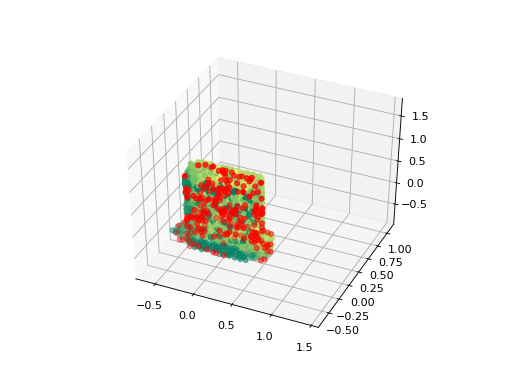

In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

print a
def show_fig(inp, adv):
    inp = np.asarray(inp)
    adv = np.asarray(adv)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')

    X,Y,Z = np.hsplit(inp,3)
    scat = ax.scatter(X,Y,Z,c=Y,cmap='summer')
    
    X,Y,Z = np.hsplit(adv,3)
    scat = ax.scatter(X,Y,Z, c='r')
    
    max_range = np.asarray([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()-X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()-Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()-Z.min())

    for xb,yb,zb in zip(Xb,Yb,Zb):
        ax.plot([xb],[yb],[zb], 'r')

    plt.grid()
    plt.show()
show_fig(inputs[0], adversaries[0]) 

In [8]:
plt.clf()
plt.hist(times)
plt.show()
print np.mean(times)
print zeros

14.363234519958496
1


In [9]:
def random_point(inp, label, model):
    x = copy.deepcopy(inp)
    y = np.argmax(label)
    order_point = np.random.permutation(point_in_cloud)
    removed = []
    removed_ind = []
    for i in order_point:
        _replace = x[i]
        x[i] = [0,0,0] 
        conf, cl = predict(x,model)
        removed.append(_replace)
        removed_ind.append(i)
        if(cl != y):
            return len(removed), x, removed, removed_ind   
    return len(removed), x, removed, removed_ind 
        
times_rand = []
scores_rand = []
inputs_rand = []
adversaries_rand = []
zeros_rand = 0
for i in trange(samples):
    index = i
    start = time.time()
    a,b,c,d = random_point(x_test[index], y_test[index], model)
    end = time.time()
    scores_rand.append(a)
    if(a == 0):
        zeros_rand += 1
    else:
        times_rand.append(end-start)
        inputs_rand.append(b)
        adversaries_rand.append(c)

100%|██████████| 10/10 [02:11<00:00, 13.14s/it]


<IPython.core.display.Javascript object>


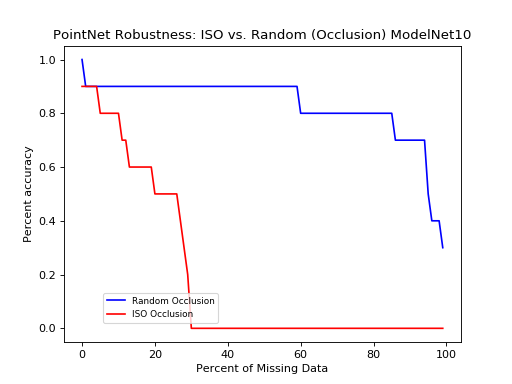

13.134221506118774


In [10]:
percent_correct_random = 1.00
percent_correct_optimized = 1.00

potr = [] # percent over time random
poto = [] # percent over time optimized

opt_manip_dist = scores
rand_manip_dist = scores_rand
sono = sorted(opt_manip_dist)
srno = sorted(rand_manip_dist)

# You need to make sure that this number is the same as the 
# number of points you tested with ISO otherwise the figure
# will report the wrong percentages
samples = 10
point_in_cloud = float(point_in_cloud)


for i in range(100):
    #print 2048.0*(i/100.0)
    #print 2048.0*(i+1/100.0)
    for x in srno:
        if(x <= point_in_cloud*(i/100.0) and x > point_in_cloud*((i-1)/100.0)):
            percent_correct_random -= 1.0/samples
            
    for x in sono:
        if(x <= point_in_cloud*(i/100.0) and x > point_in_cloud*((i-1)/100.0)):
            percent_correct_optimized -= 1.0/samples
            
    potr.append(percent_correct_random)
    poto.append(percent_correct_optimized)
    
fig1 = plt.figure()
plt.title('PointNet Robustness: ISO vs. Random (Occlusion) ModelNet10')
ax1 = fig1.add_subplot(111)

plt.plot(potr[0:], label="Random Occlusion", c='b')
plt.plot(poto[0:], label="ISO Occlusion", c='r')

plt.ylabel("Percent accuracy")
plt.xlabel("Percent of Missing Data")
print(np.mean(times_rand))
params = {'legend.fontsize' : 8}
plt.rcParams.update(params)
plt.legend(loc=1, bbox_to_anchor=(0.4,0.18))
plt.show()